# Systems Dynamics:

Members: Viraj Kanchan, Nathan Mayer, Shubang Mukund, Matthew Nolan

Code Written by Nathan Mayer

Code Adapted from the Triple Pendulum Example, Solving Nonlinear Four-Bar Constraints, and Falling Rod Example Code Written by Professor Daniel Aukes

Triple Pendulum Example Code: https://foldable-robotics.github.io/modules/dynamics/generated/08-triple-pendulum-example/

## System Kinematics Figure:

<img src='https://drive.google.com/uc?id=1n8KlDhqv8kxqkUDIxMgCXLMRzwZ3RAF0' width="600">

##Paper Model:

<img src='https://drive.google.com/uc?id=1UjM9wa0ghvNNOO5JXU1Iy3jgVrLcS6f2' width="300">

<img src='https://drive.google.com/uc?id=1uYPlwpIFRbJQvaMWyjlJh5Tn5gu700NQ' width="300">

<img src='https://drive.google.com/uc?id=1t2fsh0MN521ZPTDzsgL6mwciavRxpNaM' width="300">



##Pynamics Script:

In [1]:
use_constraints = True

In [2]:
# Import all necessary packages:

!pip install pynamics
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
from pynamics.constraint import AccelerationConstraint,KinematicConstraint
import pynamics.integration
import numpy
import sympy
import scipy.optimize
import matplotlib.pyplot as plt
plt.ion()
from math import pi

In [3]:
# Define Initial System:

system = System()
pynamics.set_system(__name__,system)

### Parametrization:

Link lengths were based off of dimensionless values used to create the initial Solidworks sketch, and then scaled by 1/20 to get the model to the appropriate size. Currently, the fixed horizontal link at the top of the model (link A1) is 5cm long.

Masses of the individual links and the body of the robot (not represented in simulation but referenced with respect to the ground contact forces) are somewhat arbitrary at this point but are roughly in-line with a small dog, which the system is mimicking. These values can easily be adjusted based on the material selections and electronic component choices at a later date.

In [4]:
# Create constant values for length, mass, springs, inertia, etc.

lA1 = Constant(1/20,'lA1',system)
lB1 = Constant(0.75/20,'lB1',system)
lC1 = Constant(1/20,'lC1',system)
lA2 = Constant(0.75/20,'lA2',system)
lB2 = Constant(0.5/20,'lB2',system)
lA3 = Constant(1.75/20,'lA3',system)

mA1 = Constant(0.25/2,'mA1',system)
mB1 = Constant(0.25/2,'mB1',system)
mC1 = Constant(0.25/2,'mC1',system)
mA2 = Constant(0.25/2,'mA2',system)
mB2 = Constant(0.25/2,'mB2',system)
mA3 = Constant(0.25/2,'mA3',system)
m_end = Constant(0.25,'m_end',system)

m_body = Constant(5/2,'m_body',system)

m_tot = (mA1 + mB1 + mC1 + mA2 + mB2 + mA3) * 4 + m_body

g = Constant(9.81,'g',system) # acceleration due to gravity
b = Constant(2e-1,'b',system) # damping constant
k = Constant(1e0,'k',system) # spring constant
k_ground = Constant(2e4,'k_ground',system) # ground spring constant
b_ground = Constant(5e5,'b_ground',system) # ground damping constant

# spring preloads
preload1 = Constant(0*pi/180,'preload1',system)
preload2 = Constant(0*pi/180,'preload2',system)
preload3 = Constant(0*pi/180,'preload3',system)
preload4 = Constant(0*pi/180,'preload4',system)
preload5 = Constant(0*pi/180,'preload5',system)
preload6 = Constant(0*pi/180,'preload6',system)

# link principal moments of inertia
Ixx_A1 = Constant(1,'Ixx_A1',system)
Iyy_A1 = Constant(1,'Iyy_A1',system)
Izz_A1 = Constant(1,'Izz_A1',system)
Ixx_B1 = Constant(1,'Ixx_B1',system)
Iyy_B1 = Constant(1,'Iyy_B1',system)
Izz_B1 = Constant(1,'Izz_B1',system)
Ixx_C1 = Constant(1,'Ixx_C1',system)
Iyy_C1 = Constant(1,'Iyy_C1',system)
Izz_C1 = Constant(1,'Izz_C1',system)
Ixx_A2 = Constant(1,'Ixx_A2',system)
Iyy_A2 = Constant(1,'Iyy_A2',system)
Izz_A2 = Constant(1,'Izz_A2',system)
Ixx_B2 = Constant(1,'Ixx_B2',system)
Iyy_B2 = Constant(1,'Iyy_B2',system)
Izz_B2 = Constant(1,'Izz_B2',system)
Ixx_A3 = Constant(1,'Ixx_A3',system)
Iyy_A3 = Constant(1,'Iyy_A3',system)
Izz_A3 = Constant(1,'Izz_A3',system)

# input torques and frequencies
torque1 = Constant(1e0,'torque1',system)
torque2 = Constant(1e0,'torque2',system)

freq1 = Constant(1e-1,'freq1',system)
freq2 = Constant(2e-1,'freq2',system)

qA3 = Constant(0,'qA3',system)

In [5]:
# Differentiable State Variables:

qA1,qA1_d,qA1_dd = Differentiable('qA1',system)
qB1,qB1_d,qB1_dd = Differentiable('qB1',system)
qC1,qC1_d,qC1_dd = Differentiable('qC1',system)
qA2,qA2_d,qA2_dd = Differentiable('qA2',system)
qB2,qB2_d,qB2_dd = Differentiable('qB2',system)

In [6]:
# Initial Values:

initialvalues = {}
initialvalues[qA1]=(0)*pi/180
initialvalues[qA1_d]=0*pi/180
initialvalues[qB1]=(-110)*pi/180
initialvalues[qB1_d]=0*pi/180
initialvalues[qC1]=(-40)*pi/180
initialvalues[qC1_d]=0*pi/180
initialvalues[qA2]=(-130)*pi/180
initialvalues[qA2_d]=0*pi/180
initialvalues[qB2]=(50)*pi/180
initialvalues[qB2_d]=0*pi/180


In [7]:
statevariables = system.get_state_variables()
ini = [initialvalues[item] for item in statevariables]

### Kinematics:

In [8]:
# Define All Frames:

N = Frame('N',system)
A1 = Frame('A1',system)
B1 = Frame('B1',system)
C1 = Frame('C1',system)
A2 = Frame('A2',system)
B2 = Frame('B2',system)
A3 = Frame('A3',system)

In [9]:
# Define Newtonian Frame:

system.set_newtonian(N)

In [10]:
# Define Frame Rotations:

A1.rotate_fixed_axis(N,[0,0,1],qA1,system)
B1.rotate_fixed_axis(A1,[0,0,1],qB1,system)
C1.rotate_fixed_axis(B1,[0,0,1],qC1,system)
A2.rotate_fixed_axis(N,[0,0,1],qA2,system)
B2.rotate_fixed_axis(A2,[0,0,1],qB2,system)
A3.rotate_fixed_axis(B2,[0,0,1],qA3,system)

In [11]:
# Create Point Vectors based on Frame Rotations:

pNA1 = 0*N.x
pA1B1 = pNA1 + lA1*A1.x
pB1C1 = pA1B1 + lB1*B1.x
pC1B2 = pB1C1 + lC1*C1.x

pNA2 = 0*N.x
pA2B2 = pNA2 + lA2*A2.x
pB2C1 = pA2B2 + lB2*B2.x

pB2A3 = pA2B2 + lA3*B2.x

In [12]:
# Create Particle Entity to be Used in Ground Contact Force

Particle1 = Particle(pB2A3,m_end,'Particle1',system)

In [13]:
# Create an array of points:

points = [pC1B2,pB1C1,pA1B1,pNA1,pNA2,pA2B2,pB2C1,pB2A3]

p = numpy.array(points)

In [14]:
# Plot Estimated System Position:

l = len(p)

state1 = initialvalues


px = []
for i in range(0,l):
    q = p[i]
    x = q.dot(N.x)
    px.append(x)

px1 = [item.subs(state1) for item in px]
px1 = [item.subs(system.constant_values) for item in px1]
print('px1: ')
print(px1)

py = []
for i in range(0,l):
    q = p[i]
    y = q.dot(N.y)
    py.append(y)

py1 = [item.subs(state1) for item in py]
py1 = [item.subs(system.constant_values) for item in py1]
print('py1: ')
print(py1)

pz = []
for i in range(0,l):
    q = p[i]
    z = q.dot(N.z)
    pz.append(z)

pz1 = [item.subs(state1) for item in pz]
pz1 = [item.subs(system.constant_values) for item in pz1]
print('pz1: ')
print(pz1)

px1: 
[-0.00612702556393450, 0.0371742446252874, 0.0500000000000000, 0, 0, -0.0241045353632452, -0.0197633309215720, -0.00891031981738882]
py1: 
[-0.0602384732794716, -0.0352384732794716, 0, 0, 0, -0.0287266666169617, -0.0533468604422669, -0.114897345005530]
pz1: 
[0, 0, 0, 0, 0, 0, 0, 0]


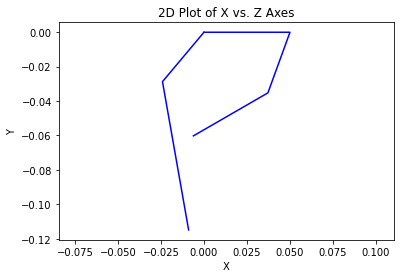

In [15]:
# 2D Plot (X vs. Z Axes)

plt.plot(px1[0:4],py1[0:4],'b')
plt.plot(px1[4:l],py1[4:l],'b')
plt.axis('equal')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Plot of X vs. Z Axes');

### Solve for valid initial condition determined by independent variable:

In [16]:
# Setup Optimization Equations:

ini0 = [initialvalues[item] for item in statevariables]

eq_vector = [pB2C1-pC1B2] # Output Should be Zero when End Points from Each Segment are Subtracted

eq_scalar = []
eq_scalar.append((eq_vector[0]).dot(N.x))
eq_scalar.append((eq_vector[0]).dot(N.y))

eq_scalar

[-lA1*cos(qA1) + lA2*cos(qA2) + lB1*sin(qA1)*sin(qB1) - lB1*cos(qA1)*cos(qB1) - lB2*sin(qA2)*sin(qB2) + lB2*cos(qA2)*cos(qB2) - lC1*(-sin(qA1)*sin(qB1) + cos(qA1)*cos(qB1))*cos(qC1) - lC1*(-sin(qA1)*cos(qB1) - sin(qB1)*cos(qA1))*sin(qC1), -lA1*sin(qA1) + lA2*sin(qA2) - lB1*sin(qA1)*cos(qB1) - lB1*sin(qB1)*cos(qA1) + lB2*sin(qA2)*cos(qB2) + lB2*sin(qB2)*cos(qA2) - lC1*(-sin(qA1)*sin(qB1) + cos(qA1)*cos(qB1))*sin(qC1) - lC1*(sin(qA1)*cos(qB1) + sin(qB1)*cos(qA1))*cos(qC1)]

In [17]:
# Define Independent and Dependent Variables

qi = [qA1,qA2,qB1]
qd = [qC1,qB2]

eq_scalar_c = [item.subs(system.constant_values) for item in eq_scalar]

defined = dict([(item,initialvalues[item]) for item in qi])
eq_scalar_c = [item.subs(defined) for item in eq_scalar_c]
eq_scalar_c

error = (numpy.array(eq_scalar_c)**2).sum()


In [18]:
f = sympy.lambdify(qd,error)

def function(args):
    return f(*args)

In [19]:
# Define Initial Guess and Use Optimize Equation to Find Actual Angles:

guess = [initialvalues[item] for item in qd]

result = scipy.optimize.minimize(function,guess)
if result.fun>1e-3:
    raise(Exception("out of tolerance"))

In [20]:
# Save New Points to Plot the Actual System Results:

ini = []
for item in system.get_state_variables():
    if item in qd:
        ini.append(result.x[qd.index(item)])
    else:
        ini.append(initialvalues[item])

In [21]:
# Display Error from Optimization Equation:
result.fun

5.304033604483377e-09

2022-03-06 06:56:09,621 - pynamics.output - INFO - calculating outputs
2022-03-06 06:56:09,623 - pynamics.output - INFO - done calculating outputs


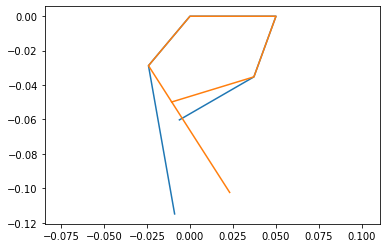

In [22]:
# Plot Calculated System (Orange) vs. Initial Guess (Blue)

points = PointsOutput(points, constant_values=system.constant_values)
points.calc(numpy.array([ini0,ini]),numpy.array([0,1]))
points.plot_time()

In [23]:
# Define a new State for Joint Angles based on Optimization Equation:

state2 = {}
state2[qA1] = initialvalues[qA1]
state2[qA1_d]= 0*pi/180
state2[qB1]= initialvalues[qB1]
state2[qB1_d] = 0*pi/180
state2[qC1] = result.x[0]
state2[qC1_d] = 0*pi/180
state2[qA2] = initialvalues[qA2]
state2[qA2_d] = 0*pi/180
state2[qB2] = result.x[1]
state2[qB2_d] = 0*pi/180

# Dynamics Simulation:

## Centers of Mass:

The centers of mass of each link are taken at the centers of their respective linear segments.

In [24]:
pA1cm=pNA1+lA1/2*A1.x
pB1cm=pA1B1+lB1/2*B1.x
pC1cm=pB1C1+lC1/2*C1.x
pA2cm=pNA2+lA2/2*A2.x
pB2cm=pA2B2+lB2/2*B2.x
pA3cm=pB2A3+lA3/2*A3.x

## Angular Velocity:

In [25]:
wNA1 = N.get_w_to(A1)
wA1B1 = A1.get_w_to(B1)
wB1C1 = B1.get_w_to(C1)
wNA2 = N.get_w_to(A2)
wA2B2 = A2.get_w_to(B2)
wB2A3 = B2.get_w_to(A3)

## Vector Derivatives:

In [26]:
vA3tip = pB2A3.time_derivative(N,system)

## Define Inertias and Bodies:

Inertias and bodies are constructed from previosly defined masses, centers of mass, and moments of intertia.

In [27]:
IA1 = Dyadic.build(A1,Ixx_A1,Iyy_A1,Izz_A1)
IB1 = Dyadic.build(B1,Ixx_B1,Iyy_B1,Izz_B1)
IC1 = Dyadic.build(C1,Ixx_C1,Iyy_C1,Izz_C1)
IA2 = Dyadic.build(A2,Ixx_A2,Iyy_A2,Izz_A2)
IB2 = Dyadic.build(B2,Ixx_B2,Iyy_B2,Izz_B2)
IA3 = Dyadic.build(A3,Ixx_A3,Iyy_A3,Izz_A3)

BodyA1 = Body('BodyA1',A1,pA1cm,mA1,IA1,system)
BodyB1 = Body('BodyB1',B1,pB1cm,mB1,IB1,system)
BodyC1 = Body('BodyC1',C1,pC1cm,mC1,IC1,system)
BodyA2 = Body('BodyA2',A2,pA2cm,mA2,IA2,system)
BodyB2 = Body('BodyB2',B2,pB2cm,mB2,IB2,system)
BodyA3 = Body('BodyA3',A3,pA3cm,mA3,IA3,system)

## Forces and Torques: (Using Pynamics Simulation)

Two sinusoidal input torques are considered acting at joints $p(NA_1)$ and $p(A_1A_2)$. These torques currently have an amplitude of 1 N*m but can be adjusted later.

Dampers and spring forces are added to each of the joints so that their values can be studied and different combinations can be tested in the future. Gravity and ground contact forces are included as well.

In [28]:
system.addforce(torque1*sympy.sin(freq1*2*sympy.pi*system.t)*A2.z,wNA2)
system.addforce(torque2*sympy.sin(freq2*2*sympy.pi*system.t)*B1.z,wA1B1)

In [29]:
# Damper:

system.addforce(-b*wNA1,wNA1)
system.addforce(-b*wA1B1,wA1B1)
system.addforce(-b*wB1C1,wB1C1)
system.addforce(-b*wNA2,wNA2)
system.addforce(-b*wA2B2,wA2B2)
system.addforce(-b*wB2A3,wB2A3)

In [30]:
# Spring Forces:

system.add_spring_force1(k,(qA1-preload1)*N.z,wNA1) 
system.add_spring_force1(k,(qB1-preload2)*A1.z,wA1B1)
system.add_spring_force1(k,(qC1-preload3)*B1.z,wB1C1)
system.add_spring_force1(k,(qA2-preload4)*N.z,wNA2) 
system.add_spring_force1(k,(qB2-preload5)*A2.z,wA2B2)
system.add_spring_force1(k,(qA3-preload6)*B2.z,wB2A3)

(<pynamics.force.Force at 0x7f0e064e5150>,
 <pynamics.spring.Spring at 0x7f0e064e5790>)

In [31]:
# Gravity:

system.addforcegravity(-g*N.y)

In [32]:
# Ground Contact Force

y1 = pB2A3.dot(N.y)

f_floor1 = ((y1 + 0.11)**2)**.5 - (y1 + 0.11)    # Assume Ground at y = -0.11

f_floor1_d = system.derivative(f_floor1)
system.addforce(-k_ground*f_floor1*-N.y,vA3tip)
system.addforce(-b_ground*f_floor1*vA3tip,vA3tip)
#system.addforce(-b_ground*f_floor1*f_floor1_d*-N.y,vA3tip)

In [33]:
# End Effector Force:
# (Defined Force as One Quarter of Total Mass per Leg)

# system.addforce(0.43*m_tot*g*N.y,pB2A3)

## Constraints:

Because this system is a parallel mechanism, acceleration constraints are required to keep the two "sides" of the mechanism connected throughout their motion while also keeping the top link fixed in place.

In [34]:
if use_constraints:

    eq1 = []
    eq1.append(pB2C1-pC1B2)
    eq1_d=[item.time_derivative() for item in eq1]
    eq1_dd=[item.time_derivative() for item in eq1_d]
    eq1_dd_scalar = []
    eq1_dd_scalar.append(eq1_dd[0].dot(N.x))
    eq1_dd_scalar.append(eq1_dd[0].dot(N.y))

    eq2 = []
    eq2.append(pA1B1)
    eq2_d=[item.time_derivative() for item in eq2]
    eq2_dd=[item.time_derivative() for item in eq2_d]
    eq2_dd_scalar = []
    eq2_dd_scalar.append(eq2_dd[0].dot(N.y))

    constraint1 = AccelerationConstraint(eq1_dd_scalar)
    constraint2 = AccelerationConstraint(eq2_dd_scalar)

    system.add_constraint(constraint1)  # Kinematic Constraint
    system.add_constraint(constraint2)  # Ground Connection at pA1B1 Constraint

## F = ma

In [35]:
f,ma = system.getdynamics()

2022-03-06 06:56:10,665 - pynamics.system - INFO - getting dynamic equations


In [36]:
f

[-b*qA1_d - g*lA1*mA1*cos(qA1)/2 - g*lA1*mB1*cos(qA1) - g*lA1*mC1*cos(qA1) + g*lB1*mB1*sin(qA1)*sin(qB1)/2 - g*lB1*mB1*cos(qA1)*cos(qB1)/2 + g*lB1*mC1*sin(qA1)*sin(qB1) - g*lB1*mC1*cos(qA1)*cos(qB1) - g*lC1*mC1*(-sin(qB1)*sin(qC1) + cos(qB1)*cos(qC1))*cos(qA1)/2 - g*lC1*mC1*(-sin(qB1)*cos(qC1) - sin(qC1)*cos(qB1))*sin(qA1)/2 - k*(-preload1 + qA1), -b*qB1_d + g*lB1*mB1*sin(qA1)*sin(qB1)/2 - g*lB1*mB1*cos(qA1)*cos(qB1)/2 + g*lB1*mC1*sin(qA1)*sin(qB1) - g*lB1*mC1*cos(qA1)*cos(qB1) - g*lC1*mC1*(-sin(qB1)*sin(qC1) + cos(qB1)*cos(qC1))*cos(qA1)/2 - g*lC1*mC1*(-sin(qB1)*cos(qC1) - sin(qC1)*cos(qB1))*sin(qA1)/2 - k*(-preload2 + qB1) + torque2*sin(2*freq2*pi*t), -b*qC1_d - g*lC1*mC1*(-sin(qB1)*sin(qC1) + cos(qB1)*cos(qC1))*cos(qA1)/2 - g*lC1*mC1*(-sin(qB1)*cos(qC1) - sin(qC1)*cos(qB1))*sin(qA1)/2 - k*(-preload3 + qC1), -b*qA2_d - b_ground*lA2**2*qA2_d*(-lA2*sin(qA2) - lA3*sin(qA2)*cos(qB2) - lA3*sin(qB2)*cos(qA2) + ((lA2*sin(qA2) + lA3*sin(qA2)*cos(qB2) + lA3*sin(qB2)*cos(qA2) + 0.11)**2)**0.5 

In [37]:
ma

[Izz_A1*qA1_dd + Izz_B1*(qA1_dd + qB1_dd) + Izz_C1*(qA1_dd + qB1_dd + qC1_dd) + lA1**2*mA1*qA1_dd/4 + lA1**2*mB1*qA1_dd + lA1**2*mC1*qA1_dd + lA1*lB1*mB1*qA1_d**2*sin(qB1)/2 + lA1*lB1*mB1*qA1_dd*cos(qB1)/2 - lA1*lB1*mB1*(qA1_d + qB1_d)**2*sin(qB1)/2 + lA1*lB1*mC1*qA1_d**2*sin(qB1) + lA1*lB1*mC1*qA1_dd*cos(qB1) - lA1*lB1*mC1*(qA1_d + qB1_d)**2*sin(qB1) + lA1*mB1*(lB1*qA1_dd/2 + lB1*qB1_dd/2)*cos(qB1) + lA1*mC1*(lB1*qA1_dd + lB1*qB1_dd)*cos(qB1) + lA1*(-lC1*mC1*(qA1_d + qB1_d + qC1_d)**2*sin(qC1)/2 + mC1*(lC1*qA1_dd/2 + lC1*qB1_dd/2 + lC1*qC1_dd/2)*cos(qC1))*cos(qB1) + lA1*(-lC1*mC1*(qA1_d + qB1_d + qC1_d)**2*cos(qC1)/2 - mC1*(lC1*qA1_dd/2 + lC1*qB1_dd/2 + lC1*qC1_dd/2)*sin(qC1))*sin(qB1) + lB1*lC1*mC1*(qA1_d + qB1_d)**2*sin(qC1)/2 - lB1*lC1*mC1*(qA1_d + qB1_d + qC1_d)**2*sin(qC1)/2 + lB1*mB1*(lB1*qA1_dd/2 + lB1*qB1_dd/2)/2 + lB1*mC1*(lB1*qA1_dd + lB1*qB1_dd) + lB1*mC1*(lC1*qA1_dd/2 + lC1*qB1_dd/2 + lC1*qC1_dd/2)*cos(qC1) + lC1*mC1*(lB1*qA1_dd + lB1*qB1_dd)*cos(qC1)/2 + lC1*mC1*(lC1*qA1_

## Solve for Acceleration:

In [38]:
func1,lambda1 = system.state_space_post_invert(f,ma,return_lambda = True)

2022-03-06 06:56:12,459 - pynamics.system - INFO - solving a = f/m and creating function
2022-03-06 06:56:13,648 - pynamics.system - INFO - substituting constrained in Ma-f.
2022-03-06 06:56:14,637 - pynamics.system - INFO - done solving a = f/m and creating function
2022-03-06 06:56:14,643 - pynamics.system - INFO - calculating function for lambdas


## Integration Tolerance:

In [39]:
tol = 1e-5

In [40]:
# Time:

tinitial = 0
tfinal = 10
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

## Integrate:

In [41]:
states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

2022-03-06 06:56:14,777 - pynamics.integration - INFO - beginning integration
2022-03-06 06:56:14,782 - pynamics.system - INFO - integration at time 0000.00
2022-03-06 06:56:16,641 - pynamics.integration - INFO - finished integration


## Outputs:

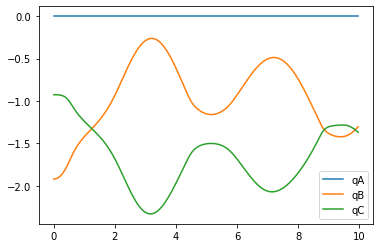

In [42]:
# States:

plt.figure()
artists = plt.plot(t,states[:,:3])
plt.legend(artists,['qA','qB','qC'])

2022-03-06 06:56:17,754 - pynamics.output - INFO - calculating outputs
2022-03-06 06:56:17,831 - pynamics.output - INFO - done calculating outputs


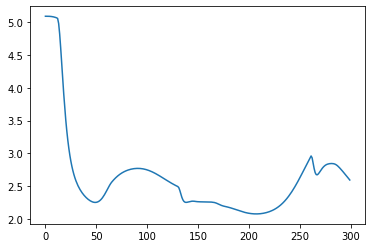

In [43]:
# Energy:

KE = system.get_KE()
PE = system.getPEGravity(pNA1) - system.getPESprings()
energy_output = Output([KE-PE],system)
energy_output.calc(states,t)
energy_output.plot_time()

Note that the total energy  of the system does not purely decay over time because the sinusoidal input torques add energy to the system.

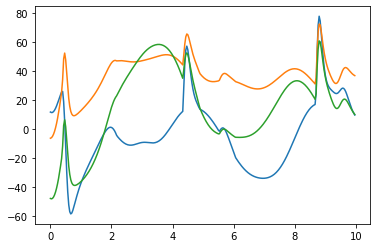

In [44]:
# Constraint Forces:

if use_constraints:
    lambda2 = numpy.array([lambda1(item1,item2,system.constant_values) for item1,item2 in zip(t,states)])
    plt.figure()
    plt.plot(t, lambda2)

2022-03-06 06:56:19,515 - pynamics.output - INFO - calculating outputs
2022-03-06 06:56:19,619 - pynamics.output - INFO - done calculating outputs


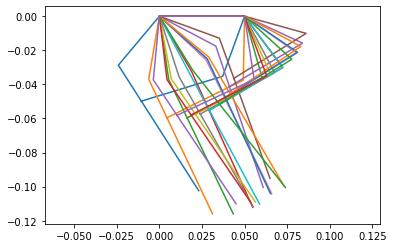

In [45]:
# Motion:

points = [pC1B2,pB1C1,pA1B1,pNA1,pNA2,pA2B2,pB2C1,pB2A3]
points_output = PointsOutput(points,system)
y = points_output.calc(states,t)
points_output.plot_time(20)

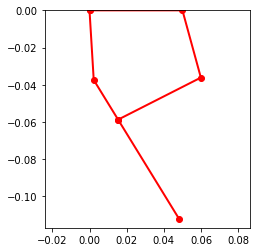

In [46]:
# Motion Animation:

points_output.animate(fps = fps,movie_name = 'triple_pendulum.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')
from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())

## Tuning

Add the negative of the input torques in order to cancel them out, because there is no obvious way to remove a force from the system. The dynamics equations are then re-solved and the total energy of the system is plotted over time.

In [47]:
system.addforce(-torque1*sympy.sin(freq1*2*sympy.pi*system.t)*A2.z,wNA2)
system.addforce(-torque2*sympy.sin(freq2*2*sympy.pi*system.t)*B1.z,wA1B1)

In [48]:
f2,ma2 = system.getdynamics()
func2,lambda2 = system.state_space_post_invert(f2,ma2,return_lambda = True)
states2=pynamics.integration.integrate(func2,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

2022-03-06 06:57:14,735 - pynamics.system - INFO - getting dynamic equations
2022-03-06 06:57:16,511 - pynamics.system - INFO - solving a = f/m and creating function
2022-03-06 06:57:17,073 - pynamics.system - INFO - substituting constrained in Ma-f.
2022-03-06 06:57:17,812 - pynamics.system - INFO - done solving a = f/m and creating function
2022-03-06 06:57:17,815 - pynamics.system - INFO - calculating function for lambdas
2022-03-06 06:57:17,821 - pynamics.integration - INFO - beginning integration
2022-03-06 06:57:17,824 - pynamics.system - INFO - integration at time 0000.00
2022-03-06 06:57:19,082 - pynamics.integration - INFO - finished integration


2022-03-06 06:57:19,340 - pynamics.output - INFO - calculating outputs
2022-03-06 06:57:19,388 - pynamics.output - INFO - done calculating outputs


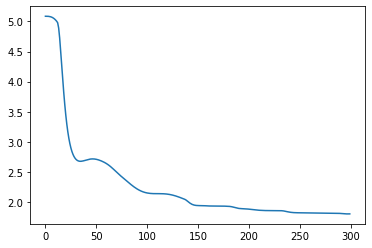

In [49]:
# Energy:

KE = system.get_KE()
PE = system.getPEGravity(pNA1) - system.getPESprings()
energy_output = Output([KE-PE],system)
energy_output.calc(states2,t)
energy_output.plot_time()

Note that with the input torques removed, the system energy settles toward zero as it should.

## Bibliography:

[1] J. Kim, K. A. Kazmierczak, and G. J. Breur, “Comparison of temporospatial and kinetic variables of walking in small and large dogs on a pressure-sensing walkway,” *American Journal of Veterinary Research*, vol. 72, no. 9, pp. 1171–1177, 2011. 